In [211]:
import pandas as pd
import numpy as np
import category_encoders as ce
from matplotlib import pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [212]:
course_df = pd.read_csv('../data/course_prepared.csv', header=0, encoding='unicode_escape')
course_df['Enrolled Ratio'] = course_df['Enrolled'] / course_df['Cap']
course_df.head()

,Course,TF_IDF,Term,Term Yr,Class Yr,Dept Desc,Cap,Enrolled,Enrolled Ratio
0,CSC 111,1.999042,Fall,2019,1,Computer Science,400.0,346.0,0.865000
1,CSC 115,1.697958,Fall,2019,1,Computer Science,150.0,130.0,0.866667
2,CSC 115,1.697958,Summer,2019,1,Computer Science,115.0,86.0,0.747826
3,CSC 225,1.727549,Fall,2019,2,Computer Science,215.0,197.0,0.916279
4,CSC 225,1.727549,Summer,2019,2,Computer Science,145.0,63.0,0.434483


In [213]:
X_train, X_test = train_test_split(course_df, test_size=0.2, random_state=42)
print(f"Train: {len(X_train)}, Test: {len(X_test)}")

enrollment = X_train.drop(columns='Enrolled', axis='columns')
enrollment_labels = X_train['Enrolled'].copy()

Train: 176, Test: 44


In [214]:
# Separate our attributes depending on their desired transformations
num_attribs = ['Class Yr', 'Term Yr','TF_IDF']
cat_attribs = ['Term', 'Dept Desc']
log_attribs = ['Cap']
basen_attribs = ['Course']

numeric_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder())
])

log_pipeline = Pipeline([
    ('log', FunctionTransformer(np.log, feature_names_out="one-to-one")),
    ('scaler', StandardScaler())
])

basen_pipeline = Pipeline([
    ('base_encoder', ce.BaseNEncoder(base=15, cols=basen_attribs))
])

preprocessing = ColumnTransformer([
    ('numeric_transformer', numeric_pipeline, num_attribs),
    ('categorical_transformer', categorical_pipeline, cat_attribs),
    ('ordinal_transformer', basen_pipeline, basen_attribs),
    ('log_transformer', log_pipeline, log_attribs),
], remainder='passthrough', verbose_feature_names_out=False)

In [215]:
enrollment_prepared = preprocessing.fit_transform(enrollment)

In [216]:
preprocessing.get_feature_names_out()

array(['Class Yr', 'Term Yr', 'TF_IDF', 'Term_Fall', 'Term_Spring',
       'Term_Summer', 'Dept Desc_Computer Science',
       'Dept Desc_Electrical & Computer Engg',
       'Dept Desc_Engineering & Computer Science', 'Course_0', 'Course_1',
       'Cap', 'Enrolled Ratio'], dtype=object)

In [226]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

regressors = [
    RandomForestRegressor(random_state=42),
    GradientBoostingRegressor(random_state=42, learning_rate=0.12, max_leaf_nodes=10, n_estimators=200),
]

evaluation_metrics = {}
for idx, regressor in enumerate(regressors):
    curr_regressor = make_pipeline(preprocessing, regressor)
    curr_regressor.fit(enrollment, enrollment_labels)

    predictions = curr_regressor.predict(enrollment)

    rmses = -cross_val_score(curr_regressor, 
                             enrollment, 
                             enrollment_labels,
                             scoring="neg_root_mean_squared_error",
                             cv=10)
    
    evaluation_metrics[str(regressors[idx])] = [np.mean(rmses), predictions, curr_regressor]

for regressor, out_tuple in evaluation_metrics.items():
    print(f"{regressor}: RMSE score = {out_tuple[0]}")

best_regressor = min(evaluation_metrics, key=evaluation_metrics.get)
print(f"\nBest regressor: {best_regressor}")

RandomForestRegressor(random_state=42): RMSE score = 18.62738385028413
GradientBoostingRegressor(learning_rate=0.12, max_leaf_nodes=10,
                          n_estimators=200, random_state=42): RMSE score = 14.701707007511079

Best regressor: GradientBoostingRegressor(learning_rate=0.12, max_leaf_nodes=10,
                          n_estimators=200, random_state=42)


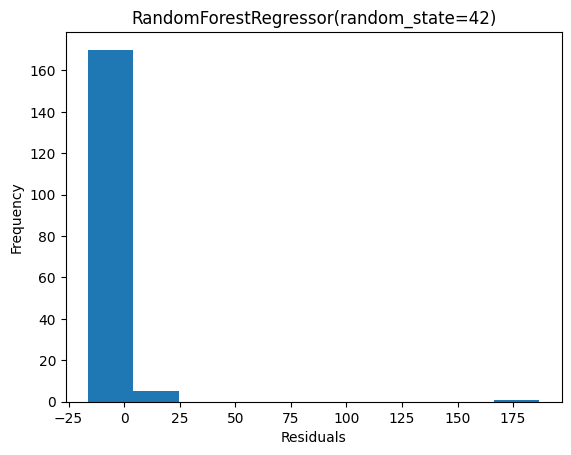

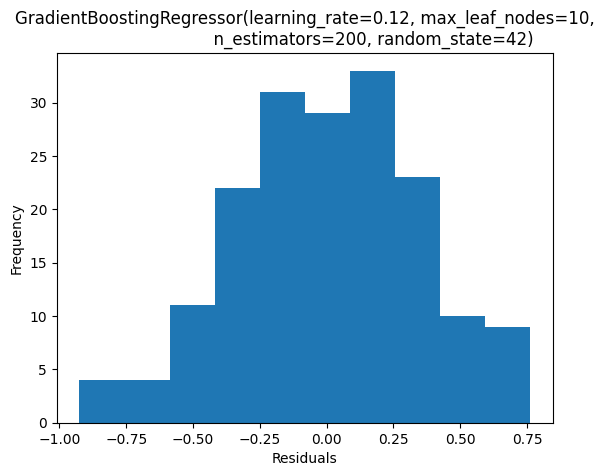

In [227]:
for regressor, out_tuple in evaluation_metrics.items():
    residuals = enrollment_labels - out_tuple[1]
    plt.hist(residuals)
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.title(f"{regressor}")
    plt.show()

In [219]:
final_metrics = {}
for regressor, attributes in evaluation_metrics.items():
    enrolled_predictions = attributes[2].predict(X_test)
    final_mse = mean_squared_error(X_test['Enrolled'], enrolled_predictions, squared=False)

    final_metrics[regressor] = final_mse
    print(f"{regressor}: Final RMSE score = {final_mse}")

print(f"\nBest Regressor: {min(final_metrics, key=final_metrics.get)}")

RandomForestRegressor(random_state=42): Final RMSE score = 6.802105456133685
GradientBoostingRegressor(random_state=42): Final RMSE score = 5.2734221615691315

Best Regressor: GradientBoostingRegressor(random_state=42)


In [221]:
# Perform a randomized grid search to find the best parameters for GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

# Will need to be updated each time features are modified
param_grid = [
    {'gradientboostingregressor__n_estimators': [1, 2, 5, 10, 20, 50, 100, 200, 500],
     'gradientboostingregressor__max_leaf_nodes': [2, 5, 10, 20, 50, 100],
     'gradientboostingregressor__learning_rate': [0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.0]}
]

to_be_searched = list(evaluation_metrics.keys())[1]
gb_reg = evaluation_metrics[to_be_searched][2]
grid_search = RandomizedSearchCV(gb_reg, 
                                 param_grid, 
                                 cv=10,
                                 scoring='neg_root_mean_squared_error',
                                 n_iter=60,
                                 random_state=42)
grid_search.fit(enrollment, enrollment_labels)

/Users/bhavy/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/model_selection/_search.py:313: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  yield param_grid[i]
/Users/bhavy/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/model_selection/_search.py:313: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  yield param_grid[i]
/Users/bhavy/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/model_selection/_search.py:313: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  yield param_grid[i]
/Users/bhavy/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/model_selection/_search.py:313: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  yield param_grid[i]


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('numeric_transformer',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Class '
                                                                                'Yr',
                                                                                'Term '
                                                                                'Yr',
                                                                                'TF_IDF']),
                                                                              ('categorical_transformer',
                                                                               Pipeline(steps=[('encoder',
                                                                                                OneHotEncoder())]),
                                                                               ['Term',
                                                                                'Dept '
                                                                                'Desc']),
                                                                              ('ordinal_transformer'...
                                              GradientBoostingRegressor(random_state=42))]),
                   n_iter=60,
                   param_distributions=[{'gradientboostingregressor__learning_rate': [0.01,
                                                                                      0.12,
                                                                                      0.23,
                                                                                      0.34,
                                                                                      0.45,
                                                                                      0.56,
                                                                                      0.67,
                                                                                      0.78,
                                                                                      0.89,
                                                                                      1.0],
                                         'gradientboostingregressor__max_leaf_nodes': [2,
                                                                                       5,
                                                                                       10,
                                                                                       20,
                                                                                       50,
                                                                                       100],
                                         'gradientboostingregressor__n_estimators': [1,
                                                                                     2,
                                                                                     5,
                                                                                     10,
                                                                                     20,
                                                                                     50,
                                                                                     100,
                                                                                     200,
                                                     

In [222]:
# Print the best parameters
print(grid_search.best_estimator_)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Class Yr', 'Term Yr',
                                                   'TF_IDF']),
                                                 ('categorical_transformer',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['Term', 'Dept Desc']),
                                                 ('ordinal_transformer',
                                                  Pipeline(steps=[('base_encoder',
                                                       

In [228]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def imputed_value(rows, column):
    values = np.append(rows[column].values, [np.nan]).reshape(-1, 1)
    imputer = IterativeImputer(max_iter=10, random_state=42)
    return imputer.fit_transform(values)[-1][0]

def fill_missing(X, LUT):
    course = X['Course'].values[0]
    term = X['Term'].values[0]

    rows = LUT[(LUT['Course'] == course) & (LUT['Term'] == term)]

    X['TF_IDF'] = imputed_value(rows, 'TF_IDF')
    X['Cap'] = round(imputed_value(rows, 'Cap'), 0)
    X['Enrolled Ratio'] = imputed_value(rows, 'Enrolled Ratio')

    X['Dept Desc'] = rows['Dept Desc'].values[0]
    X['Class Yr'] = rows['Class Yr'].values[0]

    return X

In [229]:
X_new = pd.DataFrame({
    'Course': ['CSC 320'],
    'TF_IDF': [np.nan],
    'Term': ['Fall'],	
    'Term Yr': [2024],	
    'Class Yr': [np.nan],	
    'Dept Desc': [np.nan],
    'Cap': [np.nan],		
    'Enrolled Ratio': [np.nan]
})

X = fill_missing(X_new, course_df)

In [231]:
# Pass X through the best regressor
best_regressor = evaluation_metrics[min(evaluation_metrics, key=evaluation_metrics.get)][2]
prediction = round(best_regressor.predict(X)[0], 0)

print(f"For {X['Course'].values[0]} in {X['Term'].values[0]} {X['Term Yr'].values[0]}:\nWe predict {prediction} students will enroll 🎉")

For CSC 320 in Fall 2024:
We predict 109.0 students will enroll 🎉
